In [23]:
import jammy_flows
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
from torch.optim import Adam 
import math
import pandas as pd
import numpy as np
from torch.utils.tensorboard import SummaryWriter

if torch.cuda.is_available:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
import jammy_flows.helper_fns as helper_fns
import corner

In [2]:
def cart_to_sph(x, y, z):
    out = np.empty((x.shape[0], 2))

    out[:, 0] = np.arccos(z)

    atan = np.arctan2(y, x)

    mask = (x != 0) & (y != 0)
    out[mask, 1] = atan[mask]

    mask = (x==0) & (y!=0)
    out[mask, 1] = np.pi/2 * np.sign(y[mask])

    mask = (x==0) & (y==0)
    out[mask, 1] = 0

    mask = out[:, 1] < 0
    out[mask, 1] = out[mask, 1] + 2*np.pi

    return out

def sph_to_cart(theta, phi):
    x = np.sin(theta)*np.cos(phi)
    y = np.sin(theta)*np.sin(phi)
    z = np.cos(theta)
    return x, y, z




In [3]:
class HDF5PMTTable(Dataset):
    def __init__(self, filename, start, end=-1):
        super(HDF5PMTTable).__init__()
        self._hdl = h5py.File(filename)
       
        ds_groups = sorted(self._hdl["photon_tables"].keys())
        label_order = ["distance", "energy", "dir_theta", "dir_phi", "pos_theta", "pos_phi"]
       
        self.data = []
        self.weights = []
        self.labels = []

        if end==-1:
            end = len(ds_groups)
        

        for i in range(start, end):
            grp = ds_groups[i]
            
            data = self._hdl["photon_tables"][grp][:]

            data_df = pd.DataFrame(data.T, columns=["time", "pmt_id", "weight"])
            data_df = data_df.loc[data_df["weight"] > 0]


            if len(data_df) > 1000:
                data_df = data_df.sample(1000)


            data_df["weight"] = data_df.groupby("pmt_id")["weight"].transform(lambda x: x / x.sum())
            data = data_df.to_numpy()

            pmt_encoding = torch.nn.functional.one_hot(torch.LongTensor(data[:, 1] - 1), 16)

            labels = torch.empty((data.shape[0], 16 + len(label_order)), dtype=torch.float64)
            labels_d = dict(self._hdl["photon_tables"][grp].attrs)
            for i, label in enumerate(label_order):
                labels[:, i] = labels_d[label]

            #time_res = torch.DoubleTensor(data[:, 0]) - labels[:, 0] / (0.25)
            labels[:, len(label_order):] = pmt_encoding
            
            labels[:, 0] = np.log10(labels[:, 0])
            labels[:, 1] = np.log10(labels[:, 1])

            self.data.append(torch.DoubleTensor(data[:, 0]))
            self.weights.append(torch.DoubleTensor(data[:, 2]))
            self.labels.append(labels)
        
        self.data = torch.concat(self.data)
        self.weights = torch.concat(self.weights)
        self.labels = torch.concat(self.labels)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, key):
        return self.data[key], self.weights[key], self.labels[key]


class HDF5PMTTableUnWeighted(Dataset):
    def __init__(self, filename, start, end=-1):
        super(HDF5PMTTableUnWeighted).__init__()
        self._hdl = h5py.File(filename)
       
        ds_groups = sorted(self._hdl["photon_tables"].keys())
        label_order = ["distance", "energy", "dir_theta", "dir_phi", "pos_theta", "pos_phi"]
       
        self.data = []
        self.labels = []

        if end==-1:
            end = len(ds_groups)
        

        for i in range(start, end):
            grp = ds_groups[i]
            
            data = self._hdl["photon_tables"][grp][:]

            pmt_encoding = torch.nn.functional.one_hot(torch.LongTensor(data[0] - 1), 16)

            labels = torch.empty((data.shape[1], 16 + len(label_order)), dtype=torch.float64)
            labels_d = dict(self._hdl["photon_tables"][grp].attrs)
            for i, label in enumerate(label_order):
                labels[:, i] = labels_d[label]

            #time_res = torch.DoubleTensor(data[:, 0]) - labels[:, 0] / (0.25)
            labels[:, len(label_order):] = pmt_encoding
            
            labels[:, 0] = np.log10(labels[:, 0])
            labels[:, 1] = np.log10(labels[:, 1])

            self.data.append(torch.DoubleTensor(data[0]))
            self.labels.append(labels)
        
        self.data = torch.concat(self.data)
        self.labels = torch.concat(self.labels)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, key):
        return self.data[key], self.labels[key]

    """
    def __iter__(self):
        worker_info = torch.utils.data.get_worker_info()
        if worker_info is None:  # single-process data loading, return the full iterator
            iter_start = self.start
            iter_end = self.end
        else:  # in a worker process
            # split workload
            per_worker = int(math.ceil((self.end - self.start) / float(worker_info.num_workers)))
            worker_id = worker_info.id
            iter_start = self.start + worker_id * per_worker
            iter_end = min(iter_start + per_worker, self.end)

        ds_groups = sorted(self._hdl["photon_tables"].keys())
        label_order = ["distance", "energy", "dir_theta", "dir_phi", "pos_theta", "pos_phi"]
       
        for i in range(iter_start, iter_end):
            grp = ds_groups[i]
            
            data = self._hdl["photon_tables"][grp][:]
            pmt_encoding = torch.nn.functional.one_hot(torch.LongTensor(data[1] - 1), 16)

            labels = torch.empty((data.shape[1], 16 + len(label_order)), dtype=torch.float64)
            labels_d = dict(self._hdl["photon_tables"][grp].attrs)
            for i, label in enumerate(label_order):
                labels[:, i] = labels_d[label]
            
            labels[:, len(label_order):] = pmt_encoding

            yield torch.DoubleTensor(data[0]).to(device), torch.DoubleTensor(data[2]).to(device), labels.to(device)
    """




class HDF5PPhotonTable(Dataset):
    def __init__(self, filename, start, end=-1):
        super(HDF5PPhotonTable).__init__()
        self._hdl = h5py.File(filename)
       
        ds_groups = sorted(self._hdl["photons"].keys())
        label_order = ["distance", "energy", "dir_costheta", "dir_phi"]
       
        self.data = []
        self.labels = []

        if end==-1:
            end = len(ds_groups)
        

        for i in range(start, end):
            grp = ds_groups[i]
            
            data = torch.DoubleTensor(self._hdl["photons"][grp][:])

            labels = torch.empty((data.shape[1], len(label_order)), dtype=torch.float64)
            labels_d = dict(self._hdl["photons"][grp].attrs)
            for i, label in enumerate(label_order):
                labels[:, i] = np.float64(labels_d[label])
           
            labels[:, 0] = np.log10(labels[:, 0])
            labels[:, 1] = np.log10(labels[:, 1])

            
            data = data[:, :10000]
            
            data_t = torch.empty((data.shape[1], 4), dtype=torch.float64)

            data_t[:, 0] = data[0]

            xyz = data[1:4] / np.linalg.norm(data[1:4], axis=0)

            
            sph = torch.DoubleTensor(cart_to_sph(xyz[0], xyz[1], xyz[2]))

            data_t[:, 1:3] = sph
            data_t[:, 3] = data[-1] / (torch.sum(data[-1]) * data.shape[0])

            self.data.append(data_t)
            self.labels.append(labels)
        
        self.data = torch.vstack(self.data)
        self.labels = torch.concat(self.labels)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, key):
        return self.data[key], self.labels[key]


In [4]:
def read_pmt_table_hdf(fname, ix):
    with h5py.File(fname) as hdl:
        ds_groups = sorted(hdl["photon_tables"].keys())
        label_order = ["distance", "energy", "dir_theta", "dir_phi", "pos_theta", "pos_phi"]
        grp = ds_groups[ix]
                
        data = hdl["photon_tables"][grp][:]

        data_df = pd.DataFrame(data.T, columns=["time", "pmt_id", "weight"])
        data_df = data_df.loc[data_df["weight"] > 0]

        data_df["weight"] = data_df.groupby("pmt_id")["weight"].transform(lambda x: x / x.sum())

        
        labels_d = dict(hdl["photon_tables"][grp].attrs)
        
    return data_df, labels_d

def read_pmt_table_hdf_unweighted(fname, ix):
    with h5py.File(fname) as hdl:
        ds_groups = sorted(hdl["photon_tables"].keys())
        label_order = ["distance", "energy", "dir_theta", "dir_phi", "pos_theta", "pos_phi"]
        grp = ds_groups[ix]
                
        data = hdl["photon_tables"][grp][:]

        data_df = pd.DataFrame(data.T, columns=["pmt_id", "tres"])
        labels_d = dict(hdl["photon_tables"][grp].attrs)
        
    return data_df, labels_d

def read_photon_table_hdf_unweighted(fname, ix):
    with h5py.File(fname) as hdl:
        ds_groups = sorted(hdl["photons"].keys())

        label_order = ["distance", "energy", "dir_costheta", "dir_phi"]
        grp = ds_groups[ix]
                
        data = hdl["photons"][grp][:]

        data_df = pd.DataFrame(data.T, columns=["tres", "pos_x", "pos_y", "pos_z", "weight"])
        labels = torch.empty((data.shape[1], len(label_order)), dtype=torch.float64)
        labels_d = dict(hdl["photons"][grp].attrs)
        for i, label in enumerate(label_order):
            labels[:, i] = np.float64(labels_d[label])
        
        labels[:, 0] = np.log10(labels[:, 0])
        labels[:, 1] = np.log10(labels[:, 1])
        
    return data_df, labels


        

In [13]:
ds = HDF5PPhotonTable("../assets/photon_table.hd5",0 , -1)

split_len = int(np.ceil(0.9*len(ds)))

train_dataset, test_dataset = random_split(ds, [split_len, len(ds)-split_len])

train_loader = DataLoader(train_dataset, batch_size=500, shuffle=True)
test_loader= DataLoader(test_dataset, batch_size=5000)

In [14]:
len(train_loader)

1421

In [15]:
next(iter(train_loader))[0]

tensor([[7.6990e+00, 1.2418e+00, 4.0458e+00, 1.5466e-05],
        [2.3445e+01, 3.7727e-01, 3.8423e+00, 2.5931e-05],
        [9.4541e+00, 7.7099e-01, 4.5865e+00, 5.6736e-07],
        ...,
        [1.8282e+01, 9.1919e-01, 2.3042e+00, 7.9920e-06],
        [1.4528e+01, 8.5614e-01, 5.9295e+00, 4.5855e-07],
        [1.7540e+01, 1.4129e+00, 5.9019e+00, 4.9867e-05]], dtype=torch.float64)

In [41]:
pdf = jammy_flows.pdf("e1+s2", "gggg+v", conditional_input_dim=4, hidden_mlp_dims_sub_pdfs="128-128")
optim = Adam(pdf.parameters(), lr=0.0005)
writer = SummaryWriter("/tmp/tensorboard/nflow_e1s2")

data_df, labels_plot = read_photon_table_hdf_unweighted("../assets/photon_table.hd5", 30)

train_iter = 0
for epoch in range(100):
    loss = 0
    pdf = pdf.to(device)
    for (data, labels) in train_loader:
        train_iter += 1
        optim.zero_grad()

        data = data.to(device)
        inp = data[:, :3]
        w = data[:, 3] *data.shape[0]/ sum(data[:, 3])
        labels = labels.to(device)

        log_pdf, _, _ = pdf(inp, conditional_input=labels) 
        neg_log_loss = (-log_pdf * w).mean()
        neg_log_loss.backward()
        optim.step()
        loss += neg_log_loss.detach()

        writer.add_scalar('Loss/train_batch', neg_log_loss.detach(), train_iter)
       
    loss /= len(train_loader)
 
    loss_test = 0
    for (data, labels) in test_loader:
        data = data.to(device)
        inp = data[:, :3]
        w = data[:, 3] *data.shape[0]/ sum(data[:, 3])
        labels = labels.to(device)

        log_pdf, _, _ = pdf(inp, conditional_input=labels) 
        loss_test += (-log_pdf * w).mean().detach()
    
    loss_test /= len(test_loader)

    writer.add_scalar('Loss/train', loss, epoch)
    writer.add_scalar('Loss/test', loss_test, epoch)

    fig = plt.figure(figsize=(8,6))
    helper_fns.visualize_pdf(
        pdf.to("cpu"),
        fig,
        nsamples=10000,
        conditional_input=labels_plot,
        bounds=[[-50, 150], [0, np.pi], [0, 2*np.pi]],
        #s2_norm="lambert"
        );
    writer.add_figure("Flow", fig, epoch)
    
    print(f"Epoch: {epoch:d}  Loss Train: {loss:.5f}  Loss Test: {loss_test:.5f}")



Epoch: 0  Loss Train: 18.97529  Loss Test: 6.21977
Epoch: 1  Loss Train: 6.19980  Loss Test: 6.17028
Epoch: 2  Loss Train: 6.18640  Loss Test: 6.15877
Epoch: 3  Loss Train: 6.18110  Loss Test: 6.15648
Epoch: 4  Loss Train: 6.18261  Loss Test: 6.16818
Epoch: 5  Loss Train: 6.18534  Loss Test: 6.15167
Epoch: 6  Loss Train: 6.18739  Loss Test: 6.14865
Epoch: 7  Loss Train: 6.18052  Loss Test: 6.15931
Epoch: 8  Loss Train: 6.18107  Loss Test: 6.14873
Epoch: 9  Loss Train: 6.17684  Loss Test: 6.14754
Epoch: 10  Loss Train: 6.17906  Loss Test: 6.16462
Epoch: 11  Loss Train: 6.17844  Loss Test: 6.15736
Epoch: 12  Loss Train: 6.17722  Loss Test: 6.15059
Epoch: 13  Loss Train: 6.17370  Loss Test: 6.14551
Epoch: 14  Loss Train: 6.17420  Loss Test: 6.17007
Epoch: 15  Loss Train: 6.17150  Loss Test: 6.15322
Epoch: 16  Loss Train: 6.16726  Loss Test: 6.14213
Epoch: 17  Loss Train: 6.16173  Loss Test: 6.13867
Epoch: 18  Loss Train: 6.15905  Loss Test: 6.13752
Epoch: 19  Loss Train: 6.15540  Loss Tes

ValueError: Expected value argument (Tensor of shape (500, 3)) to be within the support (IndependentConstraint(Real(), 1)) of the distribution MultivariateNormal(loc: torch.Size([500, 3]), covariance_matrix: torch.Size([500, 3, 3])), but found invalid values:
tensor([[        nan,  1.7933e-01,  1.3385e+00],
        [        nan,  1.6057e+00,  9.7511e-02],
        [        nan, -1.3546e-03, -1.0605e+00],
        ...,
        [        nan,  1.4385e-01, -7.8885e-01],
        [        nan,  2.5952e-01,  6.3339e-01],
        [        nan, -2.1957e+00, -2.2935e+00]], device='cuda:0',
       dtype=torch.float64, grad_fn=<CatBackward0>)

In [42]:
data_df, labels = read_photon_table_hdf_unweighted("../assets/photon_table.hd5", 10)

fig=plt.figure(figsize=(8,6))
helper_fns.visualize_pdf(
    pdf.to("cpu"),
    fig,
    nsamples=10000,
    conditional_input=labels,
    bounds=[[-50, 150], [0, np.pi], [0, 2*np.pi]],
    #s2_norm="lambert"
    );

sph = cart_to_sph(data_df["pos_x"] / 0.21, data_df["pos_y"] / 0.21, data_df["pos_z"] / 0.21)
data_df["pos_theta"] = sph[:, 0]
data_df["pos_phi"] = sph[:, 1]
corner.corner(data_df.loc[:, ["tres", "pos_theta", "pos_phi"]], range=[[-50, 150], [0, np.pi], [0, 2*np.pi]], weights=data_df["weight"]);

NONZERO
tensor([[   0,    0],
        [   1,    0],
        [   2,    0],
        ...,
        [4037,    0],
        [4038,    0],
        [4039,    0]])
prev tensor([nan, nan, nan,  ..., nan, nan, nan], dtype=torch.float64)
feval  tensor([nan, nan, nan,  ..., nan, nan, nan], dtype=torch.float64)
f grad eval  tensor([nan, nan, nan,  ..., nan, nan, nan], dtype=torch.float64)


Exception: 

<Figure size 800x600 with 0 Axes>

In [22]:

sph = cart_to_sph(data_df["pos_x"] / 0.21, data_df["pos_y"] / 0.21, data_df["pos_z"] / 0.21)
data_df["pos_costheta"] = np.cos(sph[:, 0])
data_df["pos_phi"] = sph[:, 1]

sns.pairplot(data=data_df,  kind="hist", weights=data_df["weight"], bins=(np.linspace(-50, 150, 50), np.linspace(0, np.pi, 50)))

/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


TypeError: pairplot() got an unexpected keyword argument 'weights'

/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/chrhck/.local/lib/python3.10/site-packages/seaborn/distributions.py:410: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"


<AxesSubplot:xlabel='tres', ylabel='Count'>

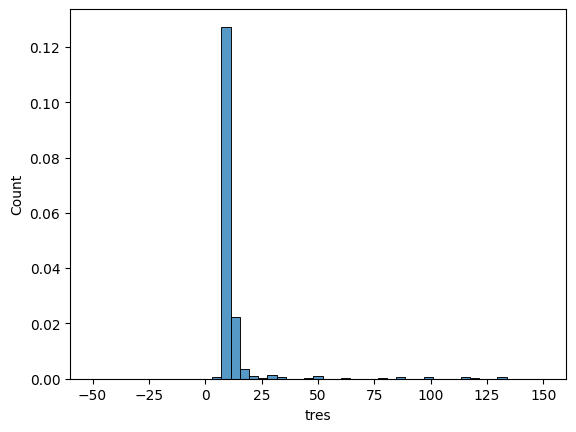

In [14]:

sph = cart_to_sph(data_df["pos_x"] / 0.21, data_df["pos_y"] / 0.21, data_df["pos_z"] / 0.21)
data_df["pos_theta"] = sph[:, 0]
data_df["pos_phi"] = sph[:, 1]

sns.histplot(data=data_df, x="tres", weights=data_df["weight"], bins=(np.linspace(-50, 150, 50)))
#sns.histplot(data=data_df, x="tres", y="pos_theta", weights=data_df["weight"], bins=(np.linspace(-50, 150, 50), np.linspace(0, np.pi, 50)))

/home/chrhck/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


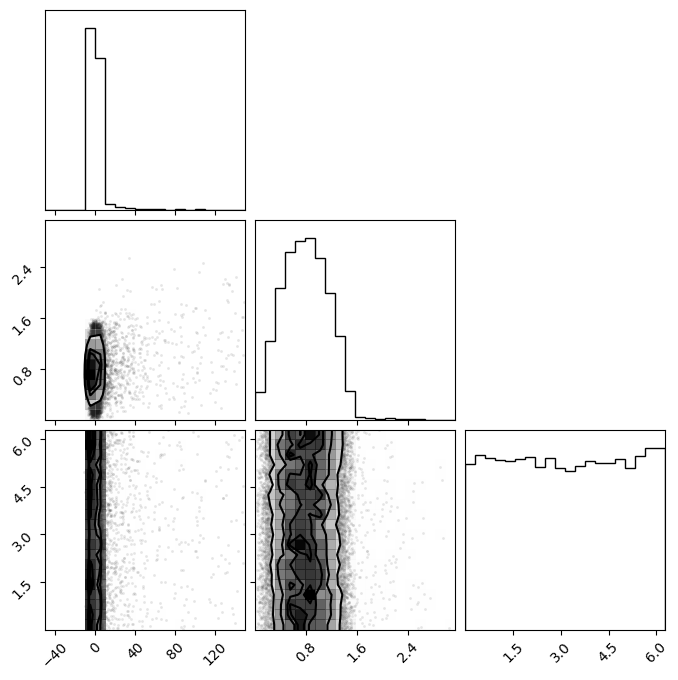

In [33]:
data_df["tres"].max()

2757.6150066785513

{'dir_costheta': 0.8359375, 'dir_phi': 5.129631754689584, 'distance': 17.518126, 'energy': 1445.9599030674115}


<AxesSubplot:>

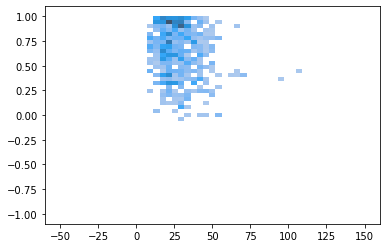

In [39]:
f = h5py.File("../assets/photon_table.hd5")
g = f["photons"]["dataset_5"]
print(dict(g.attrs))

t = g[0, :]
costheta = (g[3, :])/ 0.21
w = g[4, :] 

sns.histplot(x=t, y=costheta, weights=w, bins=(np.linspace(-50, 150, 50), np.linspace(-1, 1, 50)))



In [173]:
ds = HDF5PhotonTableUnWeighted("../assets/photon_table.hd5", 0, -1)

split_len = int(np.ceil(0.7*len(ds)))

train_dataset, test_dataset = random_split(ds, [split_len, len(ds)-split_len])

train_loader = DataLoader(train_dataset, batch_size=500, shuffle=True)
test_loader= DataLoader(test_dataset, batch_size=5000)


In [174]:
pdf = jammy_flows.pdf("e1", "gggg", conditional_input_dim=16+6, hidden_mlp_dims_sub_pdfs="128-128").to(device)
optim = Adam(pdf.parameters(), lr=0.001)
writer = SummaryWriter("/tmp/tensorboard/nflow")

train_iter = 0
for epoch in range(100):
    loss = 0
    for (times, labels) in train_loader:
        train_iter += 1
        optim.zero_grad()

        times = times.to(device)
        labels = labels.to(device)

        log_pdf, _, _ = pdf(times[:, np.newaxis], conditional_input=labels) 
        neg_log_loss = (-log_pdf).mean()
        neg_log_loss.backward()
        optim.step()
        loss += neg_log_loss.detach()

        
        writer.add_scalar('Loss/train_batch', neg_log_loss.detach(), train_iter)
       
    loss /= len(train_loader)
    

    loss_test = 0
    for (times, labels) in test_loader:
        times = times.to(device)
        labels = labels.to(device)

        log_pdf, _, _ = pdf(times[:, np.newaxis], conditional_input=labels)
        loss_test += (-log_pdf).mean().detach()
    
    loss_test /= len(test_loader)

    writer.add_scalar('Loss/train', loss, epoch)
    writer.add_scalar('Loss/test', loss_test, epoch)
    
    print(f"Epoch: {epoch:d}  Loss Train: {loss:.5f}  Loss Test: {loss_test:.5f}")



Epoch: 0  Loss Train: 7.61697  Loss Test: 0.69103
Epoch: 1  Loss Train: 0.28901  Loss Test: 0.19059
Epoch: 2  Loss Train: -0.11465  Loss Test: -0.54839
Epoch: 3  Loss Train: -0.10911  Loss Test: 0.09051
Epoch: 4  Loss Train: -0.31770  Loss Test: -0.43644
Epoch: 5  Loss Train: -0.59765  Loss Test: -1.56887
Epoch: 6  Loss Train: -0.81650  Loss Test: -1.23166
Epoch: 7  Loss Train: -0.68624  Loss Test: -0.07817
Epoch: 8  Loss Train: -0.57321  Loss Test: 0.21466
Epoch: 9  Loss Train: -0.56256  Loss Test: 1.07041
Epoch: 10  Loss Train: -0.77607  Loss Test: -1.35035
Epoch: 11  Loss Train: -1.02560  Loss Test: -0.95751
Epoch: 12  Loss Train: -0.93566  Loss Test: -1.07447
Epoch: 13  Loss Train: -1.17724  Loss Test: -1.66004
Epoch: 14  Loss Train: -1.45918  Loss Test: -1.80059
Epoch: 15  Loss Train: -1.24437  Loss Test: -0.71457
Epoch: 16  Loss Train: -1.06902  Loss Test: -1.26076
Epoch: 17  Loss Train: -1.26606  Loss Test: -1.82894
Epoch: 18  Loss Train: -1.17430  Loss Test: -1.28626
Epoch: 19 

KeyboardInterrupt: 

In [175]:
ev = read_table_hdf_unweighted("../assets/photon_table.hd5", 80)
print(ev[1])

100
{'dir_phi': 1.7590525497075664, 'dir_theta': 2.396567576390611, 'distance': 13.915788650512695, 'energy': 100000.0, 'pos_phi': 2.4195030515550093, 'pos_theta': 0.3591260640446554}


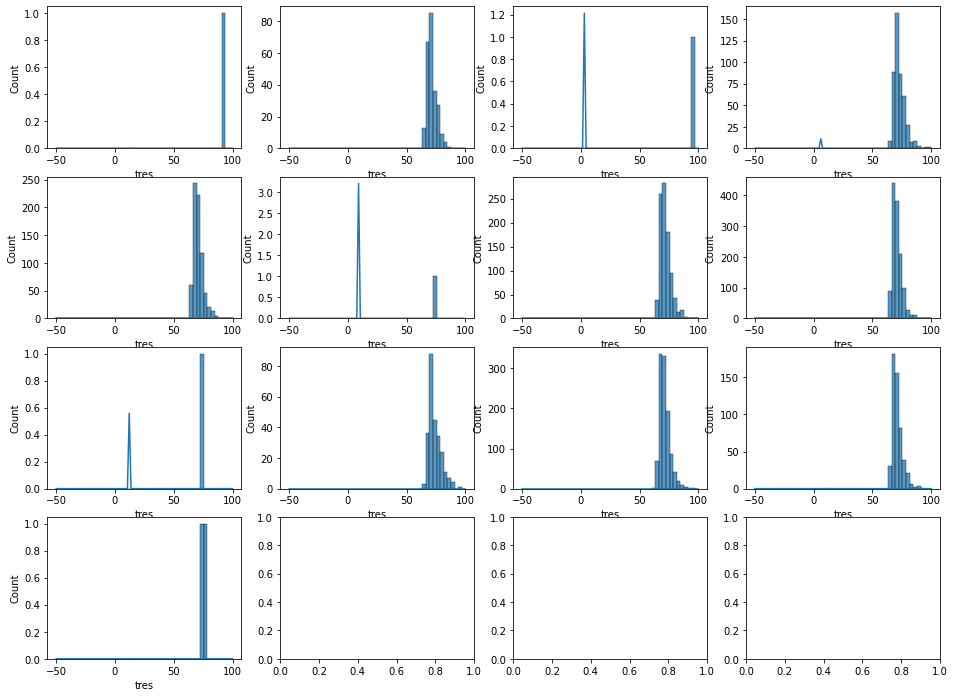

In [176]:
fig, axs = plt.subplots(4, 4, figsize=(16, 12))

label_order = ["distance", "energy", "dir_theta", "dir_phi", "pos_theta", "pos_phi"]

for i, (grpname, grp) in enumerate(ev[0].groupby("pmt_id")):
    row, col = divmod(i, 4)
    ax = axs[row][col]
    x = grp["tres"]
    #weights = grp["weight"]
    sns.histplot(x=x, bins=np.linspace(-50, 100, 50), ax=ax)

    pmt_encoding = torch.nn.functional.one_hot(torch.LongTensor([int(grpname) - 1]), 16)
    xs = torch.linspace(-50, 100, 100)
    labels = torch.empty((xs.shape[0], 16 + len(label_order)), dtype=torch.float64)
    labels_d = ev[1]
    for i, label in enumerate(label_order):
        labels[:, i] = labels_d[label]
    labels[:, len(label_order):] = pmt_encoding
    labels[:, 0] = np.log10(labels[:, 0])
    labels[:, 1] = np.log10(labels[:, 1])

    logpdf, _, _ = pdf(xs[:, np.newaxis].to(device), conditional_input=labels.to(device))
    ax.plot(xs, torch.exp(logpdf).detach().cpu() )
     



In [12]:
ev

(tensor([88.9582, 88.6213, 88.5577,  ..., 91.2363, 89.3823, 91.6626],
        dtype=torch.float64),
 tensor([1.8697e-05, 6.4915e-06, 1.9423e-08,  ..., 7.2944e-06, 2.3484e-05,
         2.6958e-08], dtype=torch.float64),
 tensor([[1.3281, 4.9531, 1.7695,  ..., 0.0000, 0.0000, 0.0000],
         [1.3281, 4.9531, 1.7695,  ..., 0.0000, 0.0000, 0.0000],
         [1.3281, 4.9531, 1.7695,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [1.3281, 4.9531, 1.7695,  ..., 0.0000, 0.0000, 0.0000],
         [1.3281, 4.9531, 1.7695,  ..., 0.0000, 0.0000, 0.0000],
         [1.3281, 4.9531, 1.7695,  ..., 0.0000, 0.0000, 0.0000]],
        dtype=torch.float64))

/home/chrhck/.local/lib/python3.10/site-packages/seaborn/distributions.py:419: UserWarning: `bins` cannot be 'auto' when using weights. Setting `bins=10`, but you will likely want to adjust.
  warnings.warn(msg, UserWarning)


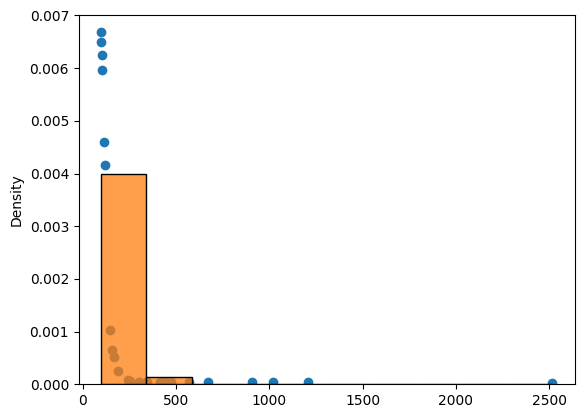

In [10]:
pdf = jammy_flows.pdf("e1", "gggg", conditional_input_dim=16+6, hidden_mlp_dims_sub_pdfs="128-128").to(device)
optim = Adam(pdf.parameters(), lr=0.001)

for epoch in range(100):
    loss = 0
    for (times, weights, labels) in train_loader:
        optim.zero_grad()

        times = times.to(device)
        labels = labels.to(device)
        weights = weights.to(device)

        weights = weights / torch.sum(weights) * len(weights)

        if any(~torch.isfinite(weights)):
            raise RuntimeError

        log_pdf, _, _ = pdf(times[:, np.newaxis], conditional_input=labels) 
        neg_log_loss = (-log_pdf * weights).mean()
        neg_log_loss.backward()
        optim.step()
        loss += neg_log_loss.detach()

    loss /= len(train_loader)
    

    loss_test = 0
    for (times, weights, labels) in test_loader:
        times = times.to(device)
        labels = labels.to(device)
        weights = weights.to(device)
        weights = weights / torch.sum(weights) * len(weights)

        log_pdf, _, _ = pdf(times[:, np.newaxis], conditional_input=labels)
        loss_test += (-log_pdf * weights).mean().detach()
    
    loss_test /= len(test_loader)

    
    print(f"Epoch: {epoch:d}  Loss Train: {loss:.5f}  Loss Test: {loss_test:.5f}")



In [10]:
test_times, test_labels = next(iter(test_dataset))

logpdf, _, _ = pdf(test_times[:, np.newaxis], conditional_input=test_labels)


In [13]:
test_times

tensor([176.8423, 178.5658], device='cuda:0', dtype=torch.float64)

<AxesSubplot: >

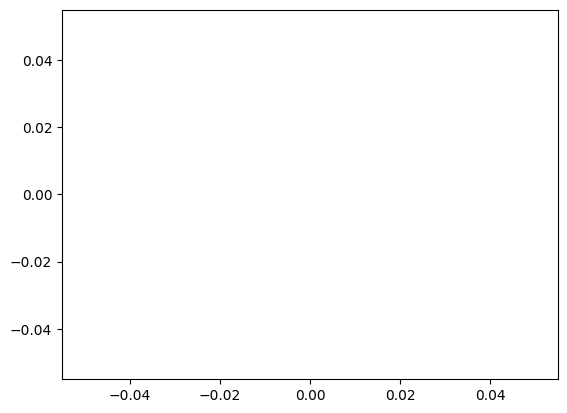

In [12]:
plt.scatter(test_times[mask].detach().cpu(), np.exp(logpdf[mask].detach().cpu()))
sns.histplot(test_times[mask].detach().cpu(), stat="density")

<AxesSubplot:ylabel='Density'>

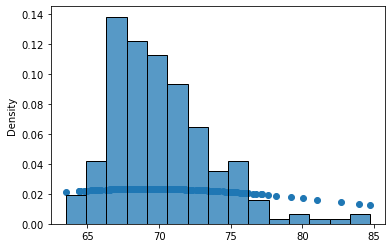

In [29]:
plt.scatter(test_per_pmt[:].detach().cpu(), np.exp(logpdf.detach().cpu()))
sns.histplot(test_per_pmt[:].detach().cpu(), stat="density")

In [34]:
labels, features = next(iter(dl))

ValueError: Shape of passed values is (2, 5126), indices imply (2, 2)

In [9]:
pdf=jammy_flows.pdf("e1", "gggg")

<KeysViewHDF5 ['dataset_1', 'dataset_10', 'dataset_11', 'dataset_12', 'dataset_2', 'dataset_3', 'dataset_4', 'dataset_5', 'dataset_6', 'dataset_7', 'dataset_8', 'dataset_9']>

In [9]:
with h5py.File("../assets/photon_table.hd5") as hdl:
    print(hdl["photon_tables/dataset_2"][:, 0])

IndexError: Index (0) out of range for empty dimension